<a href="https://colab.research.google.com/github/mitmul/medical-ai-course-materials/blob/master/notebooks/Sequential_Data_Analysis_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実践編: ディープラーニングを使ったモニタリングデータの時系列解析

- 近年, 健康意識の高まり, 運動人口の増加に伴って, 活動量計などのウェアラブルデバイスが普及し始めている.
- ウェアラブルデバイスから心拍データ等の情報を取得することで, リアルタイムに健康状態をモニタリングできる可能性がある.
  - Cardiogram社とカリフォルニア大学の共同研究で、心拍センサーデータを用いて糖尿病予備群を判定する「DeepHeart」が注目を集めた
  - Apple Watch Series 4には心電図作成の機能が搭載されており, ヘルスケア分野でも注目されている
- もう少し充実させる

## 目次

1. 環境構築
1. 使用するデータセット
1. データ前処理
1. DLを用いた時系列データ解析
1. 精度向上に向けて
  1. クラス不均衡データへの対応
    1. Undersampling
    1. 損失関数の変更
  1. 特徴抽出方法の変更
    1. 入力サイズ(セグメント長)
    1. ネットワーク構造
  1. ノイズ除去の効果検証

## 環境構築

はじめに, 下記の必要ライブラリをインストールします.

* Cupy
* Chainer
* Scipy
* Matplotlib
* Seaborn
* Pandas
* WFDB
* Scikit-learn
* Imbalanced-learn

以下のセルを実行 (Shift + Enter) して下さい. 

In [0]:
!set -ex
!apt -y -q install cuda-libraries-dev-9-2
!pip install cupy-cuda92==5.0.0
!pip install chainer==5.0.0
!pip install scipy matplotlib seaborn pandas wfdb
!pip install imbalanced-learn

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 3 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  cuda-cublas-dev-9-2 9.2.148.1-1 [50.4 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  cuda-cufft-dev-9-2 9.2.148-1 [106 MB]
Get:3 https://developer.download.nvidia.com/compute/cuda/

インストールが完了したら, 以下のセルを実行して, 各ライブラリのインポート、及びバージョン確認を行って下さい.

In [0]:
import os
import random
import numpy as np
import cupy
import chainer
import scipy
import pandas as pd
import matplotlib
import seaborn as sn
import wfdb
import sklearn
import imblearn

chainer.print_runtime_info()
print(sklearn.__version__)
print(imblearn.__version__)

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available
0.20.0
0.4.2


## 使用するデータセット

今回は、ECGデータとして有名なMIT-BIH Arrhythmia Databaseを使用します.
- TODO: 説明 - MIT-BIH DBについて
- TODO: 説明 - python-wfdbを用いてデータをダウンロード

In [0]:
dataset_root = './'
download_dir = os.path.join(dataset_root, 'download')

※エラーが出た際は, 再度実行して下さい. ↓

In [0]:
wfdb.dl_database('mitdb', dl_dir=download_dir)

Created local base download directory: ./download
Finished downloading files


- TODO: 各データの拡張子にについて軽く触れる

In [0]:
print(sorted(os.listdir(download_dir)))

['100.atr', '100.dat', '100.hea', '101.atr', '101.dat', '101.hea', '102.atr', '102.dat', '102.hea', '103.atr', '103.dat', '103.hea', '104.atr', '104.dat', '104.hea', '105.atr', '105.dat', '105.hea', '106.atr', '106.dat', '106.hea', '107.atr', '107.dat', '107.hea', '108.atr', '108.dat', '108.hea', '109.atr', '109.dat', '109.hea', '111.atr', '111.dat', '111.hea', '112.atr', '112.dat', '112.hea', '113.atr', '113.dat', '113.hea', '114.atr', '114.dat', '114.hea', '115.atr', '115.dat', '115.hea', '116.atr', '116.dat', '116.hea', '117.atr', '117.dat', '117.hea', '118.atr', '118.dat', '118.hea', '119.atr', '119.dat', '119.hea', '121.atr', '121.dat', '121.hea', '122.atr', '122.dat', '122.hea', '123.atr', '123.dat', '123.hea', '124.atr', '124.dat', '124.hea', '200.atr', '200.dat', '200.hea', '201.atr', '201.dat', '201.hea', '202.atr', '202.dat', '202.hea', '203.atr', '203.dat', '203.hea', '205.atr', '205.dat', '205.hea', '207.atr', '207.dat', '207.hea', '208.atr', '208.dat', '208.hea', '209.atr'

## データ前処理

- TODO: 説明 - ベーシックな前処理として、以下の処理を行う


1. レコードIDを train/validation/testに分割
1. 波形ファイル(.dat) & アノテーションファイル(.atr)の読み込み (一部, 利用しないデータがある)
1. 10種以上の細分化されたラベルが付与されているが, 先行研究に従って3クラスに集約する
1. 波形データの正規化
1. 2秒間の部分波形(segment)に分割. 中央のピークに付与されているラベルを, その部分波形のラベルとして扱う

In [0]:
class BaseECGDatasetPreprocessor(object):

    def __init__(
            self,
            dataset_root='./',
            window_size=720,  # 2 seconds
            random_state=45
    ):
        self.dataset_root = dataset_root
        self.download_dir = os.path.join(self.dataset_root, 'download')
        self.window_size = window_size
        self.sample_rate = 360.
        self.random_state = random_state
        self.record_list = [
            '100', '101', '103', '105', '106', '108', '109',
            '111', '112', '113', '115', '116', '117', '118',
            '119', '121', '122', '123', '124', '200', '201',
            '203', '205', '207', '208', '209', '210', '212',
            '213', '214', '215', '219', '220', '221', '222',
            '223', '228', '230', '231', '232', '233', '234'
        ]
        # split data
        self.split_record_lists = self.split_records()
        # annotation
        self.labels = ['N', 'S', 'V']
        self.valid_symbols = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E']
        self.label_map = {
            'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
            'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
            'V': 'V', 'E': 'V'
        }

    def load_data(
            self,
            base_record,
            channel=0  # [0, 1]
    ):
        record_name = os.path.join(self.download_dir, str(base_record))
        # read dat file
        signals, fields = wfdb.rdsamp(record_name)
        assert fields['fs'] == self.sample_rate
        # read annotation file
        annotation = wfdb.rdann(record_name, 'atr')
        symbols = annotation.symbol
        positions = annotation.sample
        return signals[:, channel], symbols, positions

    def normalize_signal(
            self,
            signal,
            method='std'
    ):
        if method == 'minmax':
            min_val = np.min(signal)
            max_val = np.max(signal)
            return (signal - min_val) / (max_val - min_val)
        elif method == 'std':
            signal -= np.mean(signal) / np.std(signal)
            return signal
        else:
            raise ValueError("Invalid value: {}".format(method))

    def create_data_slices(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def split_records(self):
        # copy list
        lst = list(self.record_list)
        # random shuffle
        random.seed(self.random_state)
        random.shuffle(lst)
        # split list
        record_len = len(lst)
        train_idx = int(record_len * 0.5)
        val_idx = int(record_len * 0.75)
        train_record_list = sorted(lst[:train_idx])
        validation_record_list = sorted(lst[train_idx:val_idx])
        test_record_list = sorted(lst[val_idx:])
        return train_record_list, validation_record_list, test_record_list

    def prepare_dataset(
            self,
            normalize=True
    ):
        if not os.path.isdir(self.download_dir):
            self.download_data()
        train_records, validation_records, test_records = self.split_record_lists
        # prepare training dataset
        self._prepare_dataset_core(train_records, "train", normalize)
        # prepare validation dataset
        self._prepare_dataset_core(validation_records, "validation", normalize)
        # prepare test dataset
        self._prepare_dataset_core(test_records, "test", normalize)

    def _prepare_dataset_core(
            self,
            record_list,
            mode="train",
            normalize=True
    ):
        X, y = None, None
        for i in range(len(record_list)):
            signal, symbols, positions = self.load_data(record_list[i])
            if normalize:
                signal = self.normalize_signal(signal)
            if i == 0:
                X, y = self.create_data_slices(signal, symbols, positions)
            else:
                X_tmp, y_tmp = self.create_data_slices(signal, symbols, positions)
                X = np.vstack((X, X_tmp))
                y = np.concatenate((y, y_tmp))
        os.makedirs(os.path.join(self.dataset_root, mode), exist_ok=True)
        np.save(os.path.join(self.dataset_root, mode, "X.npy"), X)
        np.save(os.path.join(self.dataset_root, mode, "y.npy"), y)


- TODO: 説明 - prepare_dataset()を実行すると, train/validation/testデータに分割され, 対応するディレクトリ内に格納される

In [0]:
preprocessor = BaseECGDatasetPreprocessor(dataset_root)

In [0]:
preprocessor.prepare_dataset()

- TODO: 説明 - train/validation のデータの中身を確認する

In [0]:
X_train = np.load(os.path.join(dataset_root, 'train', 'X.npy'))
y_train = np.load(os.path.join(dataset_root, 'train', 'y.npy'))
X_val = np.load(os.path.join(dataset_root, 'validation', 'X.npy'))
y_val = np.load(os.path.join(dataset_root, 'validation', 'y.npy'))
X_test = np.load(os.path.join(dataset_root, 'test', 'X.npy'))
y_test = np.load(os.path.join(dataset_root, 'test', 'y.npy'))

In [0]:
print("X_train.shape = ", X_train.shape, "\ty_train.shape = ", y_train.shape)
print("X_val.shape = ", X_val.shape, "\ty_val.shape = ", y_val.shape)
print("X_test.shape = ", X_test.shape, "\ty_test.shape = ", y_test.shape)

X_train.shape =  (48092, 720) 	y_train.shape =  (48092,)
X_val.shape =  (22091, 720) 	y_val.shape =  (22091,)
X_test.shape =  (25617, 720) 	y_test.shape =  (25617,)


In [0]:
uniq_train, counts_train = np.unique(y_train, return_counts=True)
print("y_train count each labels: ", dict(zip(uniq_train, counts_train)))

y_train count each labels:  {0: 42771, 1: 1678, 2: 3643}


In [0]:
uniq_val, counts_val = np.unique(y_val, return_counts=True)
print("y_val count each labels: ", dict(zip(uniq_val, counts_val)))

y_val count each labels:  {0: 20093, 1: 931, 2: 1067}


In [0]:
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print("y_test count each labels: ", dict(zip(uniq_test, counts_test)))

y_test count each labels:  {0: 23280, 1: 104, 2: 2233}


- TODO: 説明 - 波形データを可視化してみる

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

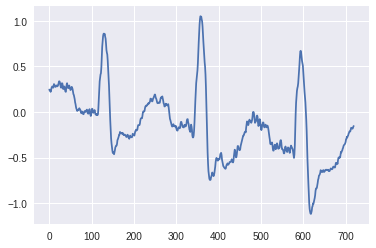

In [0]:
idx_n = np.where(y_train == 0)[0]
plt.plot(X_train[idx_n[0]])

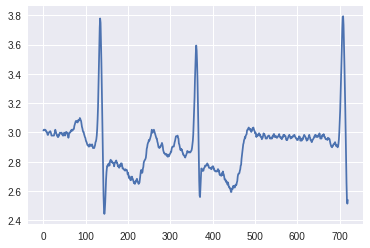

In [0]:
idx_s = np.where(y_train == 1)[0]
plt.plot(X_train[idx_s[0]])

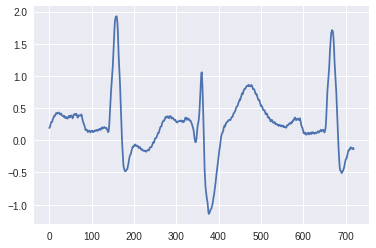

In [0]:
idx_v = np.where(y_train == 2)[0]
plt.plot(X_train[idx_v[1]])

## DLを用いた時系列データ解析

- TODO: 説明 - 3種類のクラス("N", "S", "V")を正しく識別するモデルを構築する

- TODO: 説明 - chainerデータセットクラス

In [0]:
class ECGDataset(chainer.dataset.DatasetMixin):

    def __init__(
            self,
            path
    ):
        if os.path.isfile(os.path.join(path, 'X.npy')):
            self.X = np.load(os.path.join(path, 'X.npy'))
        else:
            raise FileNotFoundError("{}/X.npy not found.".format(path))
        if os.path.isfile(os.path.join(path, 'y.npy')):
            self.y = np.load(os.path.join(path, 'y.npy'))
        else:
            raise FileNotFoundError("{}/y.npy not found.".format(path))

        assert len(self.X) == len(self.y), "len(signal): {} != len(annotation): {}".format(len(self.X), len(self.y))

    def __len__(self):
        return len(self.X)

    def get_example(self, i):
        return self.X[None, i].astype(np.float32), self.y[i]


- TODO: 説明 - CNNモデル(ResNet構造)

In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer import Variable


class ResBlock(chainer.Chain):

    def __init__(self):
        super(ResBlock, self).__init__()
        with self.init_scope():
            self.c1 = L.ConvolutionND(1, None, 32, ksize=5, pad=2)
            self.c2 = L.ConvolutionND(1, None, 32, ksize=5, pad=2)

    def __call__(self, x):
        h = F.relu(self.c1(x))
        h = x + self.c2(h)
        h = F.max_pooling_nd(F.relu(h), ksize=5, stride=2)
        return h


class ArrhythmiaNet(chainer.Chain):

    def __init__(
            self,
            n_resblock=5
    ):
        self.n_resblock = n_resblock
        super(ArrhythmiaNet, self).__init__()
        with self.init_scope():
            self.conv = L.ConvolutionND(1, None, 32, ksize=5, pad=2)
            for i in range(n_resblock):
                resblock = ResBlock()
                setattr(self, 'res{}'.format(str(i)), resblock)
            self.fc1 = L.Linear(None, 32)
            self.fc2 = L.Linear(32, 3)

    def __call__(self, x):
        h = self.conv(x)
        for i in range(self.n_resblock):
            h = getattr(self, 'res{}'.format(str(i)))(h)
        h = F.relu(self.fc1(h))
        h = self.fc2(h)
        return h


class Classifier(chainer.Chain):

    def __init__(
            self,
            predictor,
            lossfun=F.softmax_cross_entropy
    ):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
            self.lossfun = lossfun

    def __call__(self, *args):
        assert len(args) >= 2
        x = args[:-1]
        t = args[-1]
        y = self.predictor(*x)

        # loss
        loss = self.lossfun(y, t)
        with chainer.no_backprop_mode():
            # other metrics
            accuracy = F.accuracy(y, t)
            precision = F.precision(y, t, label_num=3)[0]
            recall = F.recall(y, t, label_num=3)[0]
        # reporter
        reporter.report({'loss': loss}, self)
        reporter.report({'accuracy': accuracy}, self)

        return loss

    def predict(self, x):
        with chainer.function.no_backprop_mode(), chainer.using_config('train', False):
            x = Variable(self.xp.asarray(x, dtype=self.xp.float32))
            y = self.predictor(x)
            return y
          

- TODO: 説明 - DatasetオブジェクトとTrainerオブジェクトを作成

In [0]:
from chainer import optimizers
from chainer.iterators import MultiprocessIterator
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainer.backends.cuda import get_device_from_id


def create_datasets(root_path):
    train_path = os.path.join(root_path, "train")
    validation_path = os.path.join(root_path, "validation")
    train_dataset = ECGDataset(train_path)
    validation_dataset = ECGDataset(validation_path)

    return train_dataset, validation_dataset


def create_trainer(batchsize, train_dataset, validation_dataset, device=0, lossfun=F.softmax_cross_entropy):
    # setup model
    model = ArrhythmiaNet()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999)
    optimizer.setup(train_model)

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)
    val_iter = MultiprocessIterator(validation_dataset, batchsize, repeat=False, shuffle=False)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    
    # set EarlyStoppingTrigger
    stop_trigger = triggers.EarlyStoppingTrigger(
        check_trigger=(2000 // batchsize, 'iteration'),
        patients=3,
        monitor='val/main/loss',
        max_trigger=(2, 'epoch')
    )

    # setup trainer
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy',
        'val/main/loss', 'val/main/accuracy'
        
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(1000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )
    trainer.extend(
        extensions.Evaluator(val_iter, optimizer.target, device=device),
        trigger=(2000 // batchsize, 'iteration'),
        name='val'
    )

    return trainer

In [0]:
train_dataset, validation_dataset = create_datasets(dataset_root)

In [0]:
trainer = create_trainer(200, train_dataset, validation_dataset, 0)

それでは学習を開始しましょう.

In [0]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy
0           5           1.66869     0.666                                            
0           10          0.418484    0.881          0.446358       0.914091           
0           15          0.344883    0.884                                            
0           20          0.259455    0.913          0.345663       0.923397           
0           25          0.235039    0.943                                            
0           30          0.169922    0.957          0.311444       0.91483            
0           35          0.170684    0.948                                            
0           40          0.204708    0.945          0.330687       0.899343           
0           45          0.171482    0.945                                            
0           50          0.120506    0.965          0.316404       0.906676           


- TODO: 説明文 - 学習結果を評価します

In [0]:
from chainer import cuda
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def create_test_dataset(root_path):
    test_path = os.path.join(root_path, "test")
    test_dataset = ECGDataset(test_path)
    
    return test_dataset

  
def evaluate(trainer, test_dataset, device=-1):
    model = trainer.updater.get_optimizer('main').target
    preds = []
    for i in range(len(test_dataset)):
        X, t = test_dataset.get_example(i)
        X = cuda.to_gpu(X[None, ...], device)
        y = model.predict(X)
        y = np.asscalar(cuda.to_cpu(y.data.argmax(axis=1)[0]))
        preds.append((y, t))
    pred_labels, gt_labels = zip(*preds)
    return list(pred_labels), list(gt_labels)

  
def print_confusion_matrix(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    target_names = ['N', 'S', 'V']
    cmx = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx, index=target_names, columns=target_names)
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cmx, annot=True, annot_kws={"size": 18}, fmt="d", cmap='Blues')
    plt.show()
    

def print_scores(gt_labels, pred_labels):
    target_names = ['N', 'S', 'V']
    print(classification_report(gt_labels, pred_labels, target_names=target_names))
    print("accuracy: ", accuracy_score(gt_labels, pred_labels))


In [0]:
test_dataset = create_test_dataset(dataset_root)

- TODO: 説明 - validationセットの評価

In [0]:
pred_labels_val, gt_labels_val = evaluate(trainer, validation_dataset, 0)

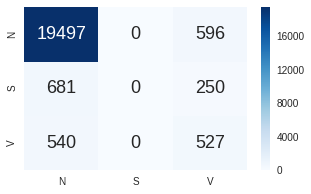

In [0]:
print_confusion_matrix(gt_labels_val, pred_labels_val)

In [0]:
print_scores(gt_labels_val, pred_labels_val)

              precision    recall  f1-score   support

           N       0.94      0.97      0.96     20093
           S       0.00      0.00      0.00       931
           V       0.38      0.49      0.43      1067

   micro avg       0.91      0.91      0.91     22091
   macro avg       0.44      0.49      0.46     22091
weighted avg       0.87      0.91      0.89     22091

accuracy:  0.906432483816939


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- TODO: 説明文 - テストセットの評価

In [0]:
pred_labels_test, gt_labels_test = evaluate(trainer, test_dataset, 0)

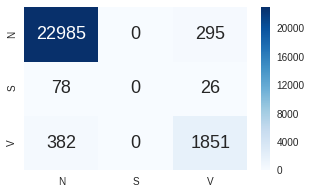

In [0]:
print_confusion_matrix(gt_labels_test, pred_labels_test)

In [0]:
print_scores(gt_labels_test, pred_labels_test)

              precision    recall  f1-score   support

           N       0.98      0.99      0.98     23280
           S       0.00      0.00      0.00       104
           V       0.85      0.83      0.84      2233

   micro avg       0.97      0.97      0.97     25617
   macro avg       0.61      0.61      0.61     25617
weighted avg       0.97      0.97      0.97     25617

accuracy:  0.9695124331498615


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 精度向上に向けて

### クラス不均衡データへの対応

* 予測スコア(Accuracy)は高かったが、単に全てのデータを'N'と予測してもValidationで90.95%、Testで90.88%の精度が出ることになる.
* クラス不均衡なデータで学習させると、大多数を占めるラベルに予測結果が偏ってしまう傾向にある => S、Vに対する予測精度が低い理由
* こうした不均衡データの問題を解消するための方法として代表的な方法が幾つかあある
    * Undersampling / Oversampling
    * 損失関数の変更


#### Undersampling




In [0]:
from imblearn.datasets import make_imbalance


class UndersampledECGDataset(ECGDataset):

    def __init__(
            self,
            path
    ):
        super(UndersampledECGDataset, self).__init__(path)
        self.X, self.y = make_imbalance(
            self.X, self.y,
            sampling_strategy={0: 4500, 1: 1500, 2: 3000}
        )

        
def create_undersampled_datasets(root_path):
    train_path = os.path.join(root_path, "train")
    validation_path = os.path.join(root_path, "validation")
    train_dataset = UndersampledECGDataset(train_path)
    validation_dataset = ECGDataset(validation_path)

    return train_dataset, validation_dataset

In [0]:
train_data, validation_data = create_undersampled_datasets(dataset_root)

In [0]:
trainer = create_trainer(200, train_dataset, validation_dataset, 0)

In [0]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy
0           5           0.604399    0.87                                             
0           10          0.341033    0.913          0.343024       0.910137           
0           15          0.249193    0.913                                            
0           20          0.176883    0.944          0.289822       0.906694           
0           25          0.201716    0.934                                            
0           30          0.107711    0.966          0.264165       0.910487           
0           35          0.189832    0.949                                            
0           40          0.153517    0.953          0.241996       0.907018           
0           45          0.115196    0.964                                            
0           50          0.128279    0.952          0.281832       0.88464            
0           55          0.0920103   0.958               

In [0]:
pred_labels_val, gt_labels_val = evaluate(trainer, validation_dataset, 0)

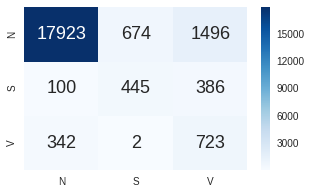

In [0]:
print_confusion_matrix(gt_labels_val, pred_labels_val)

In [0]:
print_scores(gt_labels_val, pred_labels_val)

              precision    recall  f1-score   support

           N       0.98      0.89      0.93     20093
           S       0.40      0.48      0.43       931
           V       0.28      0.68      0.39      1067

   micro avg       0.86      0.86      0.86     22091
   macro avg       0.55      0.68      0.59     22091
weighted avg       0.92      0.86      0.89     22091

accuracy:  0.8641980897197954


In [0]:
pred_labels_test, gt_labels_test = evaluate(trainer, test_dataset, 0)

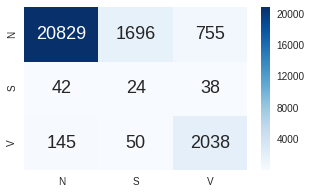

In [0]:
print_confusion_matrix(gt_labels_test, pred_labels_test)

In [0]:
print_scores(gt_labels_test, pred_labels_test)

              precision    recall  f1-score   support

           N       0.99      0.89      0.94     23280
           S       0.01      0.23      0.03       104
           V       0.72      0.91      0.80      2233

   micro avg       0.89      0.89      0.89     25617
   macro avg       0.57      0.68      0.59     25617
weighted avg       0.96      0.89      0.92     25617

accuracy:  0.8935862903540618


#### 損失関数の工夫

TODO: コード - 動かないので動くようにする

In [0]:
def focal_loss(x, t, class_num=3, alpha=0.2, gamma=2., eps=1e-7):
    xp = chainer.cuda.get_array_module(t)

    logit = F.softmax(x)
    logit = F.clip(logit, x_min=eps, x_max=1-eps)
    log_logit = F.log_softmax(x)

    t_onehot = xp.eye(class_num)[t]

    loss_ce = -1 * F.mean(t_onehot * log_logit)
    loss_focal = loss_ce * alpha * (1 - logit) ** gamma

    return loss_focal

In [0]:
train_data, validation_data = create_datasets(dataset_root)

In [0]:
trainer = create_trainer(200, train_dataset, validation_dataset, 0, lossfun=focal_loss)

In [0]:
trainer.run()

Exception in main training loop: Value must be a scalar, `numpy.ndarray`, `cupy.ndarray` or a `Variable`.
Actual: <class 'NoneType'>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/trainer.py", line 315, in run
    update()
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/updaters/standard_updater.py", line 165, in update
    self.update_core()
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/updaters/standard_updater.py", line 177, in update_core
    optimizer.update(loss_func, *in_arrays)
  File "/usr/local/lib/python3.6/dist-packages/chainer/optimizer.py", line 685, in update
    loss.backward(loss_scale=self._loss_scale)
  File "/usr/local/lib/python3.6/dist-packages/chainer/variable.py", line 963, in backward
    self._backward_main(retain_grad, loss_scale)
  File "/usr/local/lib/python3.6/dist-packages/chainer/variable.py", line 1040, in _backward_main
    func, target_input_indexes, out_grad, in_gra

TypeError: ignored

### 特徴抽出方法の変更

#### 入力サイズ(セグメント長) 変更

TODO: 説明 - より広範囲の入力情報を与えることでより特徴抽出し識別精度が向上するかを確認

In [0]:
w_preprocessor = BaseECGDatasetPreprocessor(dataset_root, window_size=1440)

In [0]:
w_preprocessor.prepare_dataset()

In [0]:
X_train = np.load(os.path.join(dataset_root, 'train', 'X.npy'))
y_train = np.load(os.path.join(dataset_root, 'train', 'y.npy'))
X_val = np.load(os.path.join(dataset_root, 'validation', 'X.npy'))
y_val = np.load(os.path.join(dataset_root, 'validation', 'y.npy'))
X_test = np.load(os.path.join(dataset_root, 'test', 'X.npy'))
y_test = np.load(os.path.join(dataset_root, 'test', 'y.npy'))

In [0]:
print("X_train.shape = ", X_train.shape, "\ty_train.shape = ", y_train.shape)
print("X_val.shape = ", X_val.shape, "\ty_val.shape = ", y_val.shape)
print("X_test.shape = ", X_test.shape, "\ty_test.shape = ", y_test.shape)

X_train.shape =  (48036, 1440) 	y_train.shape =  (48036,)
X_val.shape =  (22065, 1440) 	y_val.shape =  (22065,)
X_test.shape =  (25589, 1440) 	y_test.shape =  (25589,)


In [0]:
idx_n = np.where(y_train == 0)[0]
plt.plot(X_train[idx_n[0]])

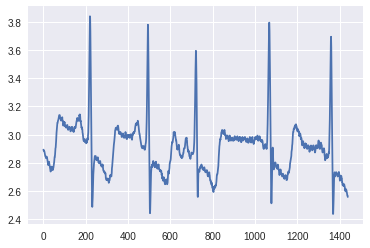

In [0]:
idx_s = np.where(y_train == 1)[0]
plt.plot(X_train[idx_s[0]])

In [0]:
idx_v = np.where(y_train == 2)[0]
plt.plot(X_train[idx_v[1]])

In [0]:
train_dataset, validation_dataset = create_datasets(dataset_root)
test_dataset = create_test_dataset(dataset_root)

In [0]:
trainer = create_trainer(200, train_dataset, validation_dataset, 0)

In [0]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy
0           5           0.638314    0.901                                            
0           10          0.342203    0.899          0.38299        0.909012           
0           15          0.299384    0.891                                            
0           20          0.25618     0.928          0.370282       0.919931           
0           25          0.216066    0.936                                            
0           30          0.15047     0.955          0.368757       0.922862           
0           35          0.166899    0.945                                            
0           40          0.154581    0.952          0.38704        0.917907           
0           45          0.142806    0.96                                             
0           50          0.133429    0.948          0.332553       0.923673           
0           55          0.121282    0.954               

In [0]:
pred_labels_val, gt_labels_val = evaluate(trainer, validation_dataset, 0)

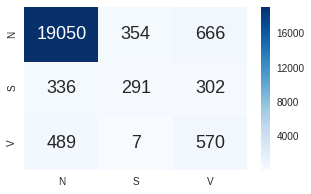

In [0]:
print_confusion_matrix(gt_labels_val, pred_labels_val)

In [0]:
print_scores(gt_labels_val, pred_labels_val)

              precision    recall  f1-score   support

           N       0.96      0.95      0.95     20070
           S       0.45      0.31      0.37       929
           V       0.37      0.53      0.44      1066

   micro avg       0.90      0.90      0.90     22065
   macro avg       0.59      0.60      0.59     22065
weighted avg       0.91      0.90      0.90     22065

accuracy:  0.9023793337865398


In [0]:
pred_labels_test, gt_labels_test = evaluate(trainer, test_dataset, 0)

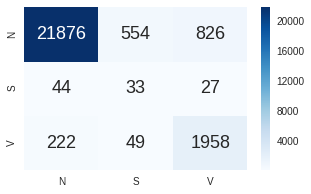

In [0]:
print_confusion_matrix(gt_labels_test, pred_labels_test)

In [0]:
print_scores(gt_labels_test, pred_labels_test)

              precision    recall  f1-score   support

           N       0.99      0.94      0.96     23256
           S       0.05      0.32      0.09       104
           V       0.70      0.88      0.78      2229

   micro avg       0.93      0.93      0.93     25589
   macro avg       0.58      0.71      0.61     25589
weighted avg       0.96      0.93      0.94     25589

accuracy:  0.932705459377076


#### ネットワーク構造の変更

In [0]:
class ArrhythmiaLSTMNet(chainer.Chain):

    def __init__(
            self,
            n_resblock=5
    ):
        self.n_resblock = n_resblock
        super(ArrhythmiaLSTMNet, self).__init__()
        with self.init_scope():
            self.conv = L.ConvolutionND(1, None, 32, ksize=5, pad=2)
            for i in range(n_resblock):
                resblock = ResBlock()
                setattr(self, 'res{}'.format(str(i)), resblock)
            self.lstm1 = L.LSTM(None, 128)
            self.lstm2 = L.LSTM(None, 128)
            self.fc1 = L.Linear(None, 32)
            self.fc2 = L.Linear(32, 3)

    def __call__(self, x):
        h = self.conv(x)
        for i in range(self.n_resblock):
            h = getattr(self, 'res{}'.format(str(i)))(h)
        h = self.lstm1(h)
        h = self.lstm2(h)
        h = F.relu(self.fc1(h))
        h = self.fc2(h)
        return h


In [0]:
def create_trainer(batchsize, train_dataset, validation_dataset, device=0, lossfun=F.softmax_cross_entropy):
    # setup model
    model = ArrhythmiaLSTMNet()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999)
    optimizer.setup(train_model)

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)
    val_iter = MultiprocessIterator(validation_dataset, batchsize, repeat=False, shuffle=False)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    
    # set EarlyStoppingTrigger
    stop_trigger = triggers.EarlyStoppingTrigger(
        check_trigger=(2000 // batchsize, 'iteration'),
        patients=3,
        monitor='val/main/loss',
        max_trigger=(2, 'epoch')
    )

    # setup trainer
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy',
        'val/main/loss', 'val/main/accuracy'
        
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(1000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )
    trainer.extend(
        extensions.Evaluator(val_iter, optimizer.target, device=device),
        trigger=(2000 // batchsize, 'iteration'),
        name='val'
    )

    return trainer

In [0]:
train_dataset, validation_dataset = create_datasets(dataset_root)

In [0]:
trainer = create_trainer(200, train_dataset, validation_dataset, 0)

In [0]:
trainer.run()

In [0]:
test_dataset = create_test_dataset(dataset_root)

- TODO: 説明 - validationセットの評価

In [0]:
pred_labels_val, gt_labels_val = evaluate(trainer, validation_dataset, 0)

In [0]:
print_confusion_matrix(gt_labels_val, pred_labels_val)

In [0]:
print_scores(gt_labels_val, pred_labels_val)

- TODO: 説明文 - テストセットの評価

In [0]:
pred_labels_test, gt_labels_test = evaluate(trainer, test_dataset, 0)

In [0]:
print_confusion_matrix(gt_labels_test, pred_labels_test)

In [0]:
print_scores(gt_labels_test, pred_labels_test)

### ノイズ除去の効果検証

- TODO: 説明 - 心電図波形には高周波ノイズ(筋電図ノイズ(Electromyogram noise)、加算性白色ガウスノイズ(Additive white Gaussian noise)力線妨害(power line interference))と、低周波ノイズ(基線変動ノイズ(baseline wandering))が含まれているため, 徐脈などの異常波形をうまく判別するために, 不要なノイズを除去する前処理を行うのが通例である
- TODO: 説明 - ノイズフィルタリングについて簡単に説明する
- TODO: MIT-BIHデータセットでは、≧0.1Hz & ≦100Hzのband-pass filterが既に適用されているが、それよりも厳しめのフィルタリングを行い, その効果を検証する(https://www.physionet.org/physiobank/database/html/mitdbdir/intro.htm#selection)



- Pros: ノイズを除くことで徐脈などの異常波形パターンを特徴として捉えやすくなる可能性がある
- Cons: 波形に含まれている重要な情報が, フィルタリングによって失われる可能性がある

In [0]:
from scipy.signal import butter, lfilter, medfilt


class DenoiseECGDatasetPreprocessor(BaseECGDatasetPreprocessor):

    def __init__(
            self,
            dataset_root='./',
            window_size=720,
            random_state=45
    ):
        super(DenoiseECGDatasetPreprocessor, self).__init__(
        dataset_root, window_size, random_state)

    def denoise_signal(
            self,
            signal,
            cutoff_low=0.3,
            cutoff_high=30.,
            order=5
    ):
        nyquist = self.sample_rate / 2.
        if cutoff_low <= 0.5 and cutoff_high >= 2.5:
            cut_off = (cutoff_low / nyquist, cutoff_high / nyquist)
            b, a = butter(order, cut_off, analog=False, btype='band')
        elif cutoff_low <= 0.5:
            cut_off = cutoff_low / nyquist
            b, a = butter(order, cut_off, analog=False, btype='high')
        elif cutoff_high >= 2.5:
            cut_off = cutoff_high / nyquist
            b, a = butter(order, cut_off, analog=False, btype='low')
        else:
            return signal
        return lfilter(b, a, signal)

    def remove_baseline_wander(
            self,
            signal
    ):
        # first median filter to remove QRS complexes and P-waves.
        window_first = int(200 * self.sample_rate / 1000.) + 1  # 73
        signal_mid = medfilt(signal, window_first)
        # second median filter to remove T-waves.
        window_second = int(600 * self.sample_rate / 1000.) + 1 # 217
        return medfilt(signal_mid, window_second)

    def create_data_slices(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def prepare_dataset(
            self,
            denoise=False,
            remove_bw=False,
            normalize=True
    ):
        if not os.path.isdir(self.download_dir):
            self.download_data()

        train_records, validation_records, test_records = self.split_record_lists

        # prepare training dataset
        self._prepare_dataset_core(train_records, "train", denoise, remove_bw, normalize)
        # prepare validation dataset
        self._prepare_dataset_core(validation_records, "validation", denoise, remove_bw, normalize)
        # prepare test dataset
        self._prepare_dataset_core(test_records, "test", denoise, remove_bw, normalize)

    def _prepare_dataset_core(
            self,
            record_list,
            mode="train",
            denoise=False,
            remove_baseline_wander=False,
            normalize=True
    ):
        X, y = None, None
        for i in range(len(record_list)):
            signal, symbols, positions = self.load_data(record_list[i])
            if denoise:
                signal = self.denoise_signal(signal)
            if remove_baseline_wander:
                signal = self.remove_baseline_wander(signal)
            if normalize:
                signal = self.normalize_signal(signal)
            if i == 0:
                X, y = self.create_data_slices(signal, symbols, positions)
            else:
                X_tmp, y_tmp = self.create_data_slices(signal, symbols, positions)
                X = np.vstack((X, X_tmp))
                y = np.concatenate((y, y_tmp))
        os.makedirs(os.path.join(self.dataset_root, mode), exist_ok=True)
        np.save(os.path.join(self.dataset_root, mode, "X.npy"), X)
        np.save(os.path.join(self.dataset_root, mode, "y.npy"), y)


In [0]:
d_preprocessor = DenoiseECGDatasetPreprocessor(dataset_root)

TODO: 説明 - 5次のButterworth filter (band-pass)を適用してノイズ除去を行う

In [0]:
d_preprocessor.prepare_dataset(denoise=True)

In [0]:
X_train_d = np.load(os.path.join(dataset_root, 'train', 'X.npy'))
y_train_d = np.load(os.path.join(dataset_root, 'train', 'y.npy'))
X_val_d = np.load(os.path.join(dataset_root, 'validation', 'X.npy'))
y_val_d = np.load(os.path.join(dataset_root, 'validation', 'y.npy'))

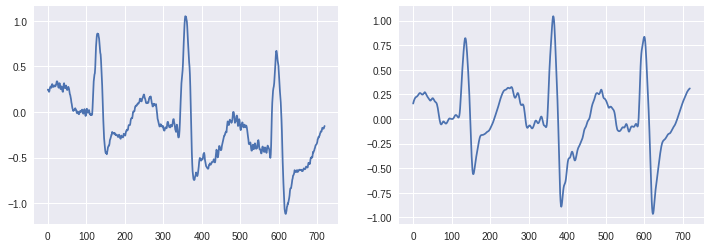

In [0]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train[idx_n[0]])
plt.subplot(1, 2, 2)
plt.plot(X_train_d[idx_n[0]])
plt.show()

左図がフィルタリング前、右図がフィルタリング後

In [0]:
train_dataset, validation_dataset = create_datasets(dataset_root)
trainer = create_trainer(200, train_dataset, validation_dataset, 0)
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy
0           50          0.238227    0.9294                                           
0           100         0.0846091   0.9721                                           
0           150         0.0452262   0.9919                                           
0           200         0.0372323   0.993          0.211192       0.917703           
1           250         0.0385774   0.9931                                           
1           300         0.0307148   0.9942                                           
1           350         0.0219792   0.9952                                           
1           400         0.0232242   0.9952         0.454147       0.875225           
1           450         0.0228253   0.9949                                           
2           500         0.0170447   0.996                                            
2           550         0.0170798   0.9959              

In [0]:
test_dataset = create_test_dataset(dataset_root)

In [0]:
pred_labels_val, gt_labels_val = evaluate(trainer, validation_dataset, 0)
print_scores(gt_labels_val, pred_labels_val)

             precision    recall  f1-score   support

          N       0.98      0.91      0.94     20093
          S       0.53      0.65      0.58       931
          V       0.32      0.73      0.45      1067

avg / total       0.93      0.89      0.90     22091

accuracy:  0.8879634240188312


In [0]:
pred_labels_test, gt_labels_test = evaluate(trainer, test_dataset, 0)
print_scores(gt_labels_test, pred_labels_test)

             precision    recall  f1-score   support

          N       1.00      0.89      0.94     23280
          S       0.02      0.38      0.04       104
          V       0.80      0.93      0.86      2233

avg / total       0.97      0.89      0.93     25617

accuracy:  0.893898582972245
